In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance, DMatrix

from tqdm import tqdm
from pickle import dump, load


In [2]:
from ml_eke import *

# Data loading

We need to load the samples. `columns` is a list in which we keep all needed predictors.

In [3]:
columns = [
           'MKE_sfc',
           'Rd_dx_sfc',
           'relative_vorticity_sfc',
           'grad_SSH_sfc',
           ]

# Pre-processing

We perform a two-step preproces for the predictors.

## First pre-processing step: logarithm where needed
- The feature `Rd_dx_z` does not need any pre-processing. We keep it as last feature, and our `regularize` function relies on this convention (i.e. the last feature is not processed).
- Some features are log-normally distributed. They are always positive, so we can simply take their logarithm, to obtain normally-distributed features. We apply this technique to the predictand feature (`EKE`) too.
- Other features follow what looks like a Laplace distribution with some outliers. In this case, we apply $f(x) = (\log(\left|x\right|)+36)*\text{sign}(x)$. This functions splits the negative and positive domains, compresses the range, is monotonic, and bijective, if and only if $|x|>10^{-15}$. Here is a plot of the function over $\mathbb{R}$.


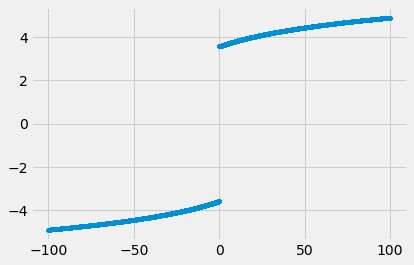

In [4]:
f = lambda x: np.log(np.abs(x)+36.0)*np.sign(x)
x_plot = np.arange(-100, 100, 1e-2)

plt.plot(x_plot, f(x_plot), '.')
plt.draw()

## Second pre-processing step: Scaling

The second pre-processing step is the same for all predictors, we scale the features so that they have approximately zero-mean and standard deviation of 1: this is usually good for Neural Network training. We do not apply this step to the predictand. We will store the scaler object, as it will be need to pre-process data at inference time.

Once the data is pre-processed, we split it into train and validation (called test here) sets.

In [5]:
def prep_data(dataset, scaler=None, skip_vars=[], abs_val=None):
    targets = dataset['EKE'].values.copy()
    data, targets, scaler = prep_samples(dataset, columns, scaler, skip_vars, abs_val)
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
    print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
    print('Dimensions of the training target vector: {}'.format(y_train.shape))
    print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
    print('Dimensions of the test target vector: {}'.format(y_test.shape))
    return X_train, X_test, y_train, y_test, scaler
    

The original dataset is computed with a resolution of 1/10th of a degree. To train the model, we use spatially averaged version of the samples. We use coarsening factors from 2 to 10, these are shortened as `cf2`, `cf3`, ...

In [6]:
datapath1 = '/lus/scratch/spartee/MOM-data/MOM6_1-10/'

datapath2 = '/lus/scratch/spartee/MOM-data/MOM6_1-10_data_with_ssh/'

model_data = pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref='cf2')
# grad_ssh is in another dataset
model_data.extend_inventory(datapath2)
samples = get_samples(0, 5, columns, model_data)
for cf_idx in range(3, 11):
    model_data = pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=f'cf{cf_idx}')
    model_data.extend_inventory(datapath2)
    scale_factor = cf_idx/2
    samples_loc = get_samples(0, min(int(np.ceil(5*scale_factor*scale_factor)), 110), columns, model_data)
    samples = pd.concat([samples,samples_loc])

Extracting samples: 100%|██████████| 110/110 [00:07<00:00, 13.94it/s]


In [7]:
X_train, X_test, y_train, y_test, scaler = prep_data(samples, abs_val=[False, True, True, False], skip_vars=['Rd_dx_sfc'])

Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(MKE_sfc)
id(Rd_dx_sfc)
log(abs(relative_vorticity_sfc))*sign
log(grad_SSH_sfc)
Fitting scaler and scaling data...
Dimensions of the training feature matrix: (44279131, 4)
Dimensions of the training target vector: (44279131,)
Dimensions of the test feature matrix: (11069783, 4)
Dimensions of the test target vector: (11069783,)


## Visual inspection of pre-processing results

Let's have a look at the resulting feature distributions. 

---------------------------------
min MKE_sfc = -10.588748931884766, max MKE_sfc = 3.7246015071868896
---------------------------------
---------------------------------
min Rd_dx_sfc = -0.6659727096557617, max Rd_dx_sfc = 10.711655616760254
---------------------------------
---------------------------------
min relative_vorticity_sfc = -1.2691807746887207, max relative_vorticity_sfc = 1.3115323781967163
---------------------------------
---------------------------------
min grad_SSH_sfc = -8.04148006439209, max grad_SSH_sfc = 5.042056560516357
---------------------------------
---------------------------------
min EKE = -12.87537956237793, max EKE = -0.26443031430244446
---------------------------------


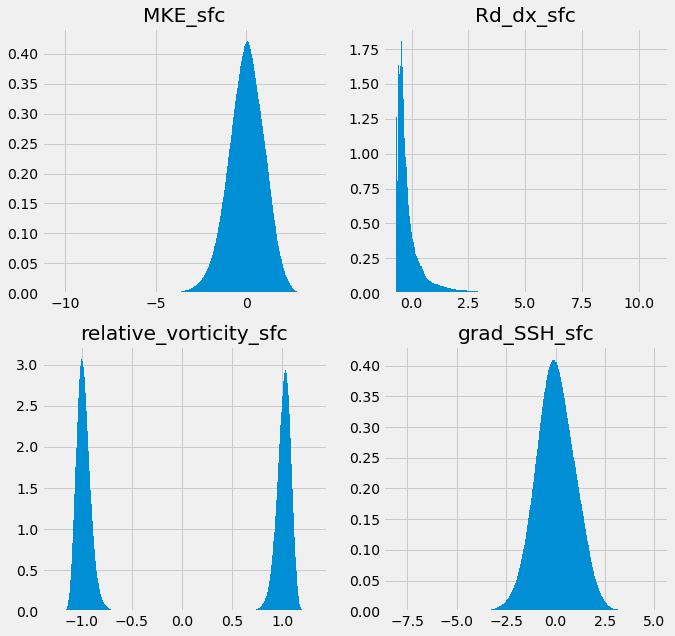

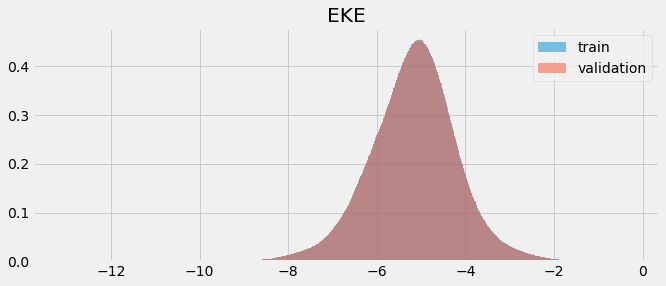

In [50]:
plt.figure(figsize=(10,5*(len(columns)//2+len(columns)%2)))
for i in range(X_train.shape[-1]):
    sample = X_train.values[:, i]
    print('---------------------------------')
    print(f'min {columns[i]} = {np.min(sample)}, max {columns[i]} = {np.max(sample)}')
    print('---------------------------------')
    plt.subplot(len(columns)//2+len(columns)%2,2,i+1)
    plt.hist(sample, bins=1000, density=True)
    plt.title(columns[i])
    plt.draw()
    
print('---------------------------------')
print(f'min EKE = {np.min(y_train)}, max EKE = {np.max(y_train)}')
print('---------------------------------')
plt.figure(figsize=(10,4))
plt.hist(y_train, bins=1000, density=True, alpha=0.5)
plt.hist(y_test, bins=1000, density=True, alpha=0.5)
plt.legend(['train', 'validation'])
plt.title('EKE')
plt.draw()

We notice that the predictand is approximately log-normally distributed. This means that we have way less samples for the values belonging to the two tails, and when we will train the neural network against mean squared error, the extremum values will therefore have less weight. We explored a possible way to mitigate this phenomenon, that is inverse sampling weighting. We approximated the distribution with a Gaussian, and we assigned to each sample the inverse of its probability. The results are in the next section.

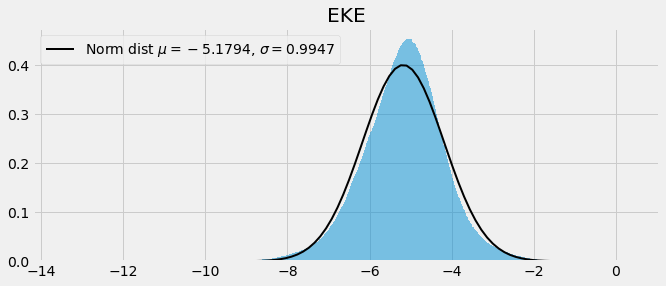

In [51]:
plt.figure(figsize=(10,4))

plt.hist(y_train, bins=1000, density=True, alpha=0.5)
xmin, xmax = plt.xlim()
mu, std = norm.fit(y_train)
x_pdf = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_pdf, mu, std)
plt.plot(x_pdf, p, 'k', linewidth=2)

plt.legend([f'Norm dist $\mu={mu:.4f}$, $\sigma={std:.4f}$'])
plt.title('EKE')
plt.draw()


In [52]:
save = False

if save:
    np.save('ml_eke/nn/data/scaler_cf_all_4', scaler)

    np.save('ml_eke/nn/data/X_train_cf_all_4', X_train.values)
    np.save('ml_eke/nn/data/X_test_cf_all_4', X_test.values)

    np.save('ml_eke/nn/data/y_train_cf_all_4', y_train)
    np.save('ml_eke/nn/data/y_test_cf_all_4', y_test)

We will now train an XGBoost regressor, to be able to compare the results of our Neural Network(s) to it. The dataset is too large for the algorithm to run in a reasonable time, thus we will use 1/100th of the data points. 

In [53]:
# If you have the data, just skip the loading and pre-processing
load_data = False
if load_data:
    scaler = np.load('./ml_eke/nn/data/scaler_cf_all_4')
    X_train = pd.DataFrame(np.load('./ml_eke/nn/data/X_train_cf_all_4.npy'), columns=columns)
    X_test =  pd.DataFrame(np.load('./ml_eke/nn/data/X_test_cf_all_4.npy'), columns=columns)

    y_train = np.load('./ml_eke/nn/data/y_train_cf_all_4.npy')
    y_test = np.load('./ml_eke/nn/data/y_test_cf_all_4.npy')

In [54]:
rf = XGBRegressor()
num_samples = X_train.shape[0]
rf.fit(X_train[:num_samples//100], y_train[:num_samples//100]) 
rf.save_model('./ml_eke/nn/data/xgbreg_new')
y_train_rf = rf.predict(X_train[:num_samples//100])
y_test_rf = rf.predict(X_test)
rf_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'training error': [mean_squared_error(y_train[:num_samples//100], y_train_rf)],
            'test error': [mean_squared_error(y_test, y_test_rf)],
            'training_r2_score': [r2_score(y_train[:num_samples//100], y_train_rf)],
            'test_r2_score': [r2_score(y_test, y_test_rf)]})
rf_results

,algorithm,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.537545,0.558827,0.459191,0.435838


The regressor can give us an important insight into the data, we can see what the most relevant features are.

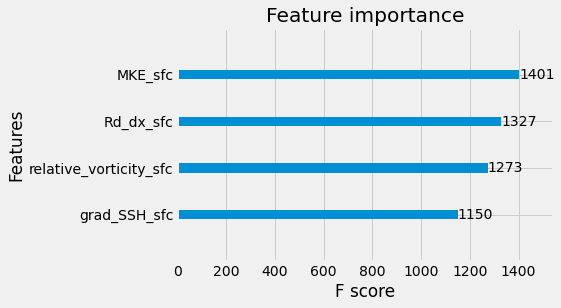

In [55]:
plot_importance(rf)

plt.draw()

We see that the four features are almost equally important.

# Validation

In this section, we load two trained neural networks and compare the results. The Neural Network `model_cus` uses a weighted sampling scheme (see above) to draw training samples, whereas `model_mse` uses a standard mean squared error loss. We also load a scaler we previously saved: **notice that this scaler must be the same one used to scale the data we trained our NNs on, otherwise results will be inconsistent**.

In [49]:
import torch
from torchsummary import summary

model_mse = torch.load('./ml_eke/nn/pytorch/trained_models/ResNet_4_mse.pkl', map_location=torch.device('cuda'))
model_cus = torch.load('./ml_eke/nn/pytorch/trained_models/ResNet_4_custom.pkl', map_location=torch.device('cuda'))
model_mse.eval()
model_cus.eval()
summary(model_mse, (4,))

scaler = np.load('./ml_eke/nn/data/scaler_cf_all_4.npy')

print('\nScaler info:')
for i in range(len(columns)):
    print(f'{columns[i]}: avg={scaler[0,i]}, std={scaler[1,i]}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 20, 3, 3]             740
       BatchNorm2d-2             [-1, 20, 3, 3]              40
              ReLU-3             [-1, 20, 3, 3]               0
        TransBlock-4             [-1, 20, 3, 3]               0
   ConvTranspose2d-5             [-1, 32, 5, 5]           5,792
       BatchNorm2d-6             [-1, 32, 5, 5]              64
              ReLU-7             [-1, 32, 5, 5]               0
        TransBlock-8             [-1, 32, 5, 5]               0
   ConvTranspose2d-9             [-1, 32, 7, 7]           9,248
      BatchNorm2d-10             [-1, 32, 7, 7]              64
             ReLU-11             [-1, 32, 7, 7]               0
       TransBlock-12             [-1, 32, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]             512
      BatchNorm2d-14             [-1, 1

We load the datasets we did not use to train our NNs and look at how the predicted value distributions compare to the target one.

In [42]:
datapaths = ('/lus/scratch/spartee/MOM-data/MOM6_1-10/',
             '/lus/scratch/spartee/MOM-data/MOM6_1-10_data_with_ssh/')

suffixes = ('_013_01.nc', '_013_01.nc')

columns[1] = 'Rd_dx_sfc'

model_data = pop_data(datapaths[0], datapaths[0], skip_vars = ['x','y','depth','depth_stdev'], extra_pref='cf6', first_suffix=suffixes[0])
model_data.extend_inventory(datapaths[1])

dataset = get_samples(110, 111, columns, model_data, predictands=['EKE_sfc'])
data, targets, _ = prep_samples(dataset, columns, scaler=None, abs_val=[False, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_sfc'], scale=True)
data

Extracting samples: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]

Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(MKE_sfc)
id(Rd_dx_sfc)
log(abs(relative_vorticity_sfc))*sign
log(grad_SSH_sfc)
Fitting scaler and scaling data...


,MKE_sfc,Rd_dx_sfc,relative_vorticity_sfc,grad_SSH_sfc
0,0.869870,-0.508886,-1.057642,1.712743
1,1.392382,-0.476744,1.081912,1.333040
2,-0.387708,-0.669746,0.947615,0.211716
3,-0.018713,-0.680482,-1.007312,0.481379
4,-0.179654,-0.687257,-1.020225,-0.580076
...,...,...,...,...
136379,-1.740041,-0.491486,-1.052961,0.474062
136380,-1.372888,-0.431863,-1.037507,3.130016
136381,-1.371738,-0.547102,-1.087173,2.785175
136382,-1.993001,-0.537939,-1.119795,1.769094


In [43]:
# Depending on what the device is
predict_cpu = lambda model, X: model(torch.tensor(X.values)).detach().numpy()
predict_gpu = lambda model, X: model(torch.tensor(X.values).cuda()).cpu().detach().numpy()

predict = predict_gpu

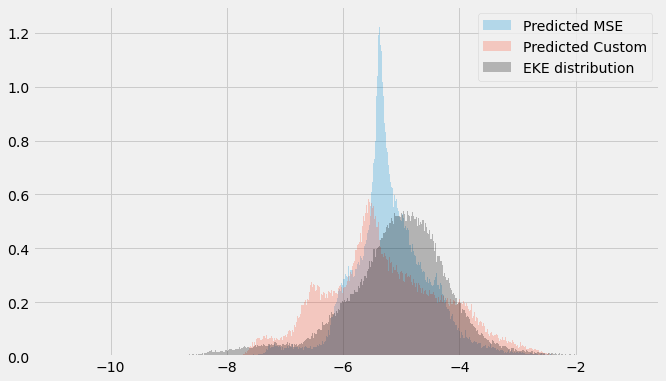

In [44]:
# make some predictions
preds_mse = predict(model_mse, data)
preds_cus = predict(model_cus, data)

# show true distribution vs predicted
plt.figure(figsize=(10,6))
plt.hist(preds_mse,bins=500,alpha=0.25,label='Predicted MSE', density=True)
plt.hist(preds_cus,bins=500,alpha=0.25,label='Predicted Custom', density=True)
plt.hist(targets,bins=500,alpha=0.25,label='EKE distribution', density=True, color='black')

plt.legend()
plt.draw()

We clearly see that the standard MSE function tends to overfit the samples close to the mean, but does poorly on the distribution tails. The weighted sampling scheme leads to more spread in the predictions, but goes too far in that direction. A mixed approach will have to be investigated in the future.

To display the results in a meaningful way, we keep the original samples as maps, instead of collecting single point values. 

In [45]:
sample, target, mask = get_samples_2D(119, 120, columns, model_data, predictands=['EKE_sfc'])
disp_sample, disp_target, disp_pred_mse = prep_maps(sample, target, mask, columns, scaler=scaler, model=model_mse, predict_fn=predict,
                                                    abs_val=[False, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_sfc'])

_, _, disp_pred_cus = prep_maps(sample, target, mask, columns, scaler=scaler, model=model_cus, predict_fn=predict,
                                abs_val=[False, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_sfc'])

Extracting 2D samples: 0it [00:00, ?it/s]


Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(MKE_sfc)
id(Rd_dx_sfc)
log(abs(relative_vorticity_sfc))*sign
log(grad_SSH_sfc)
Scaling data with provided scaler...
Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(MKE_sfc)
id(Rd_dx_sfc)
log(abs(relative_vorticity_sfc))*sign
log(grad_SSH_sfc)
Scaling data with provided scaler...


We start by plotting the predicted values for the two different NNs. We can see that they perform better on the high-resolution dataset, less on the coarser one. Two possible reasons are: the ratio between the number of fine- and coarse-grained samples is ~25:1, this means that the network will be trained mostly on high-resolution samples; the information (and thus the prediction) might be more accurate when less averaging takes place.

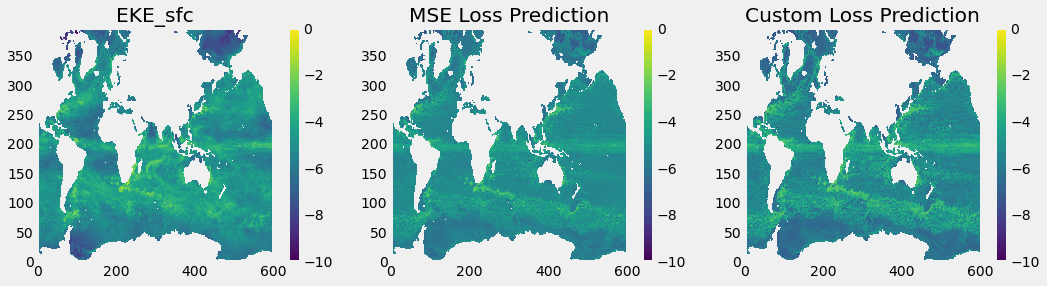

In [46]:
mask_s = mask.squeeze()
plt.figure(figsize=(16,4))

vmin = -10
vmax = 0

plt.subplot(1,3,1)
plt.pcolormesh(disp_target, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('EKE_sfc')
plt.subplot(1,3,2)
plt.pcolormesh(disp_pred_mse, vmin=vmin, vmax=vmax)
plt.title('MSE Loss Prediction')
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(disp_pred_cus, vmin=vmin, vmax=vmax)
plt.title('Custom Loss Prediction')
plt.colorbar()
plt.draw()



We plot the error for the two models.

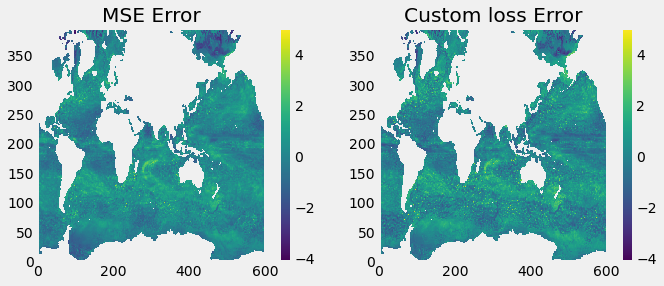

In [47]:
plt.figure(figsize=(10,4))

disp_err_mse = disp_target - disp_pred_mse
disp_err_cus = disp_target - disp_pred_cus

vmin = min(np.min(disp_err_mse[mask_s]),
           np.min(disp_err_cus[mask_s]))
vmax = max(np.max(disp_err_mse[mask_s]),
           np.max(disp_err_cus[mask_s]))

plt.subplot(1,2,1)
plt.pcolormesh(disp_err_mse, vmin=vmin, vmax=vmax)
plt.title('MSE Error')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(disp_err_cus, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Custom loss Error')
plt.draw()

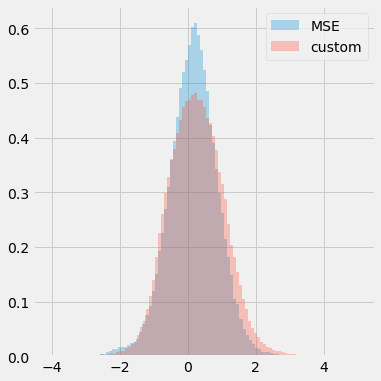

In [48]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(disp_err_mse[mask_s].reshape((-1,1)), bins=100, density=True, label='MSE', alpha=0.3)
plt.hist(disp_err_cus[mask_s].reshape((-1,1)), bins=100, density=True, label='custom', alpha=0.3)
plt.legend()
plt.draw()

We clearly see that the standard MSE loss performs better than the weighted sampling scheme. At the same time, we know that only the latter can reach the tails of the EKE distribution.